In [ ]:
!python -m spacy download es

     |████████████████████████████████| 1.7 MB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 40.3 MB/s 
     |████████████████████████████████| 15.7 MB 43.7 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=7c34180ba6c0866b5c48841eda4e0c2a477aab0919eb0b8bc1a592d4b8c490d0
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take in

#### El objetivo de este proyecto es scrappear noticas por categoria de una web "El País" y analizar los datos mediantes tópicos para ver que relación tienen las palabras con una etiqueta.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import spacy
nlp = spacy.load('es')

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

from pprint import pprint

from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from gensim.corpora import MmCorpus
from gensim.utils import simple_preprocess

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
items = ['sociedad', 'economia', 'educacion', 'ciencia', 'deportes', 'tecnologia', 'cultura']

In [ ]:
class News:

  def __init__(self, tags):

    self.base_url = 'https://elpais.com'
    self.tags = tags
    self.tag_url = None
    self.tag = None

  def get_soup(self, url: str):

    html = requests.get(url).text
    soup = BeautifulSoup(html)
    return soup
  
  def get_link(self, soup):

    links_list = []

    for i in soup.find_all('a'):
      link = i['href']

      if link.startswith(f'/{self.tag}') and link.endswith('.html'):
        link = self.base_url + link
        links_list.append(link)

    return list(set(links_list))

  def get_text(self, soup):

    text_list = []

    for i in soup.find_all('h1'):
      text_list.append(i.text)

    for i in soup.find_all('h2'):
      text_list.append(i.text)

    for i in soup.find_all('p'):
      text_list.append(i.text)

    return ' '.join(text_list)

  def get_data(self):
      
    dataset = []

    for tag in self.tags:

      self.tag_url = self.base_url + '/' + tag + '/'
      self.tag = tag

      base_soup = self.get_soup(self.tag_url)
      links = self.get_link(base_soup)
      
      for link in links:
        news_soup = self.get_soup(link)
        text = self.get_text(news_soup)
        dataset.append([tag, link, text])

    return pd.DataFrame(dataset, columns=['Tag', 'Link', 'Text'])      

In [ ]:
dataset = News(items).get_data()

In [ ]:
print(f'Cantidad de Datos y dimensiones: {dataset.shape}')

Cantidad de Datos y dimensiones: (233, 3)


In [ ]:
dataset.to_csv('dataset.csv')

In [ ]:
stopwords = spacy.lang.es.stop_words.STOP_WORDS
stopwords

In [ ]:
drops_words = ['artículos', 'suscripción', 'suscríbete', 'dispones', 'disponibles', 'suscripcion', 'promociones']

In [ ]:
def clean_text(text, stemm=False, is_string=False):
  doc = nlp(text)
  tokens = [word.text.strip() for word in doc]
  words = [i.lower() for i in tokens if i not in stopwords and len(i) > 3]
  if stemm:
    words = list(set([stemmer.stem(i) for i in words]))
  words = [i for i in words if i not in drops_words]

  if is_string:
    words = ' '.join(words)
  
  return words

In [ ]:
dataset['TextClean'] = dataset['Text'].apply(lambda x: clean_text(x, is_string=True))
dataset['TextCleanToken'] = dataset['Text'].apply(lambda x: clean_text(x, is_string=False))

dataset['TextCleanStemmer'] = dataset['Text'].apply(lambda x: clean_text(x, True, True))
dataset['TextCleanStemmerToken'] = dataset['Text'].apply(lambda x: clean_text(x, True, False))

In [ ]:
dataset.head(10)

,Tag,Link,Text,TextClean,TextCleanStemmer,TextCleanToken,TextCleanStemmerToken
0,sociedad,https://elpais.com/sociedad/la-huella/2021-09-...,"El incendio, el colibrí y la economía circular...",incendio colibrí economía circular fuego devor...,niss naveg energ direct nacional tripl sacrifi...,"[incendio, colibrí, economía, circular, fuego,...","[niss, naveg, energ, direct, nacional, tripl, ..."
1,sociedad,https://elpais.com/sociedad/proyecto-origen/20...,Castaños y pinares para restaurar el paisaje g...,castaños pinares restaurar paisaje gallego arr...,favorec naveg direct zon mont 2021 qued concre...,"[castaños, pinares, restaurar, paisaje, galleg...","[favorec, naveg, direct, zon, mont, 2021, qued..."
2,sociedad,https://elpais.com/sociedad/2021-12-16/cuatro-...,Cuatro catedráticos de Penal diseccionan el au...,cuatro catedráticos penal diseccionan auto jua...,zon testifical result qued llamat quej sexist ...,"[cuatro, catedráticos, penal, diseccionan, aut...","[zon, testifical, result, qued, llamat, quej, ..."
3,sociedad,https://elpais.com/sociedad/2021-12-15/la-agen...,La agencia de salud pública europea insta a lo...,agencia salud pública europea insta hospitales...,pes encuentr agenci añad mont estas capac terc...,"[agencia, salud, pública, europea, insta, hosp...","[pes, encuentr, agenci, añad, mont, estas, cap..."
4,sociedad,https://elpais.com/sociedad/pienso-luego-actuo...,Camino Olvidado: el renacimiento de 680 kilóme...,camino olvidado renacimiento kilómetros natura...,llan naveg zon magdalen estas construccion top...,"[camino, olvidado, renacimiento, kilómetros, n...","[llan, naveg, zon, magdalen, estas, construcci..."
5,sociedad,https://elpais.com/sociedad/la-ciencia-que-nos...,El rostro femenino del cáncer de pulmón La inc...,rostro femenino cáncer pulmón incorporación mu...,quimioterapi naveg direct vicent result qued a...,"[rostro, femenino, cáncer, pulmón, incorporaci...","[quimioterapi, naveg, direct, vicent, result, ..."
6,sociedad,https://elpais.com/sociedad/la-ciencia-que-nos...,Nuevas estrategias contra el cáncer del amiant...,nuevas estrategias cáncer amianto masivo amian...,august fibr pluvial estam quimioterapi naveg d...,"[nuevas, estrategias, cáncer, amianto, masivo,...","[august, fibr, pluvial, estam, quimioterapi, n..."
7,sociedad,https://elpais.com/sociedad/comer-sano-en-fami...,Adiós al aceite de palma La grasa vegetal más ...,adiós aceite palma grasa vegetal utilizada sec...,oliv plat ayudart pued encuentr pas naveg neut...,"[adiós, aceite, palma, grasa, vegetal, utiliza...","[oliv, plat, ayudart, pued, encuentr, pas, nav..."
8,sociedad,https://elpais.com/sociedad/2021-12-16/sanidad...,Sanidad autoriza la dosis de recuerdo para may...,sanidad autoriza dosis recuerdo mayores años p...,president vulner polic dari nacional ingles 89...,"[sanidad, autoriza, dosis, recuerdo, mayores, ...","[president, vulner, polic, dari, nacional, ing..."
9,sociedad,https://elpais.com/sociedad/2021-12-15/asi-es-...,"Así es la vacunación contra la covid de 3,3 mi...",vacunación covid millones niños empezado este ...,aquell biontech pas agenci vulner veran ingles...,"[vacunación, covid, millones, niños, empezado,...","[aquell, biontech, pas, agenci, vulner, veran,..."


topic sociedad


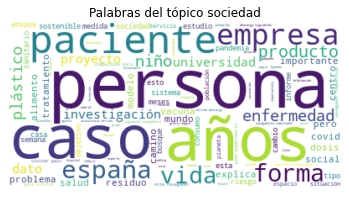

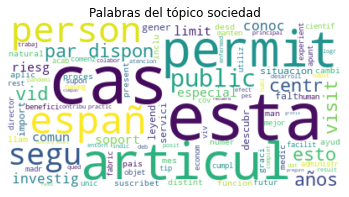



topic economia


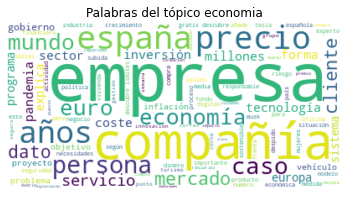

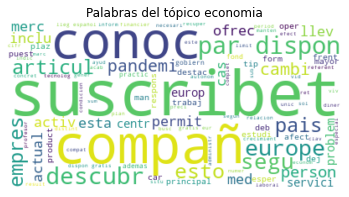



topic educacion


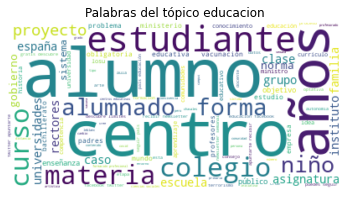

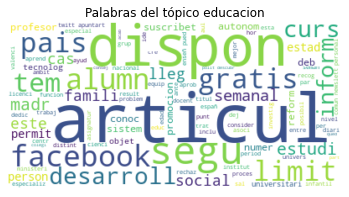



topic ciencia


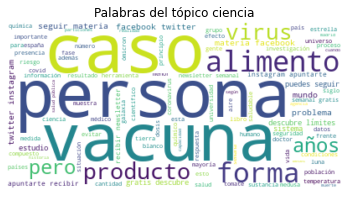

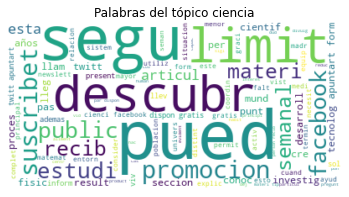



topic deportes


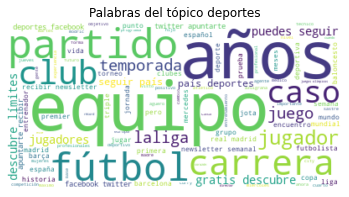

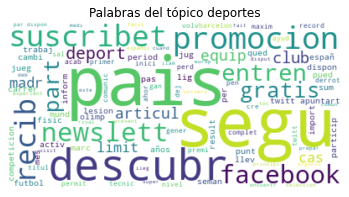



topic tecnologia


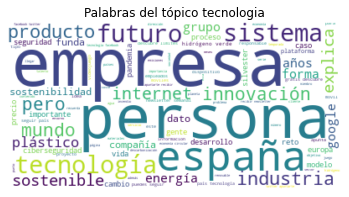

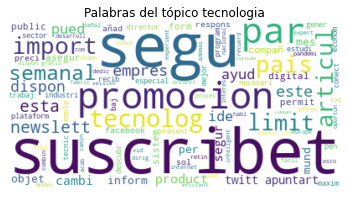



topic cultura


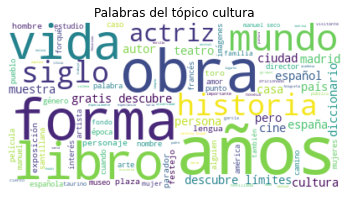

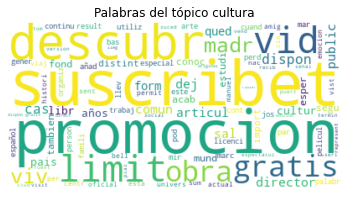

In [ ]:
pos = 1
for topic in items:

  print(f'topic {topic}')
    
  data = dataset[dataset.Tag == topic]
  
  words = ' '.join(data['TextClean'])
  wordcloud = WordCloud(max_font_size=80, max_words=100, background_color="white").generate(words)
  
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"Palabras del tópico {topic}")

  plt.show()

  wordsStemmer = ' '.join(data['TextCleanStemmer'])
  wordcloud1 = WordCloud(max_font_size=80, max_words=100, background_color="white").generate(wordsStemmer)

  plt.imshow(wordcloud1, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"Palabras del tópico {topic}")

  plt.show()
  print('\n')

#### Como podemos observar entre la limpieza de datos con Stemmer y sin Stemmer las palabras son cortadas y no son claras de observar o entender.

#### Para esta versión del proyecto utilizaremos ambos y veremos las diferencias

In [ ]:
def tokenize_and_stem(sentence):
  doc = nlp(sentence)
  tokens = [word.text.strip() for word in doc if len(word.text.strip()) > 0 and word.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'] ] 
  return tokens

def create_count_vectorizer(documents):
  count_vectorizer = CountVectorizer(stop_words=stopwords, tokenizer=tokenize_and_stem, max_features=1500)
  data = count_vectorizer.fit_transform(documents)
  return (count_vectorizer, data)

def create_and_fit_lda(data, num_topics):
  lda = LDA(n_components=num_topics, n_jobs=-1)
  lda.fit(data)
  return lda

def create_lda_model(id_dict, corpus, num_topics):
    lda_model = LdaModel(corpus=corpus,
                         id2word=id_dict,
                         num_topics=num_topics, 
                         random_state=100,
                         chunksize=100,
                         passes=10)
    return lda_model
    
def get_most_common_words_for_topics(model, vectorizer, n_top_words):
  words = vectorizer.get_feature_names()
  word_dict = {}
  for topic_index, topic in enumerate(model.components_):
    this_topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    word_dict[topic_index] = this_topic_words
  return word_dict

def print_topic_words(word_dict):
  for key in word_dict.keys():
    print(f"Topic {key}")
    print("\t", word_dict[key])

def test_new_example(lda, vect, example):
  vectorized = vect.transform([example])
  topic = lda.transform(vectorized)
  print(topic)
  return topic

In [ ]:
(vectorizer, data) = create_count_vectorizer(dataset['TextClean'].values)
lda = create_and_fit_lda(data, len(items))
topic_words = get_most_common_words_for_topics(lda, vectorizer, 10)
print_topic_words(topic_words)

Topic 0
	 ['años', 'niños', 'dosis', 'vacunación', 'personas', 'virus', 'vacuna', 'casos', 'covid', 'vacunas']
Topic 1
	 ['años', 'español', 'equipo', 'descubre', 'límites', 'millones', 'fútbol', 'euros', 'carrera', 'país']
Topic 2
	 ['empresas', 'sostenible', 'futuro', 'años', 'empresa', 'millones', 'residuos', 'innovación', 'plástico', 'mundo']
Topic 3
	 ['años', 'forma', 'educación', 'explica', 'universidades', 'país', 'ciudad', 'formación', 'camino', 'arte']
Topic 4
	 ['productos', 'alimentos', 'tipo', 'salud', 'consumo', 'diabetes', 'vida', 'forma', 'años', 'dieta']
Topic 5
	 ['personas', 'forma', 'formación', 'datos', 'social', 'materia', 'país', 'información', 'empresas', 'alumnos']
Topic 6
	 ['pacientes', 'inflación', 'enfermedad', 'tipos', 'interés', 'forma', 'paciente', 'psoriasis', 'precios', 'economía']


In [ ]:
(vectorizer, data) = create_count_vectorizer(dataset['TextCleanStemmer'].values)
lda = create_and_fit_lda(data, len(items))
topic_words = get_most_common_words_for_topics(lda, vectorizer, 10)
print_topic_words(topic_words)

Topic 0
	 ['articul', 'segu', 'años', 'especial', 'actual', 'español', 'suscribet', 'adquir', 'tecnolog', 'lleg']
Topic 1
	 ['articul', 'segu', 'suscribet', 'señal', 'especial', 'español', 'pequeñ', 'años', 'principal', 'actual']
Topic 2
	 ['articul', 'especial', 'segu', 'español', 'suscribet', 'años', 'nivel', 'menor', 'principal', 'dificil']
Topic 3
	 ['articul', 'segu', 'español', 'objet', 'años', 'tecnolog', 'facil', 'españ', 'nivel', 'principal']
Topic 4
	 ['articul', 'segu', 'español', 'años', 'especial', 'profesional', 'menor', 'suscribet', 'fundamental', 'par']
Topic 5
	 ['articul', 'principal', 'segu', 'años', 'empres', 'actual', '2022', 'nivel', 'crisis', 'especial']
Topic 6
	 ['segu', 'articul', 'facil', 'años', 'actual', 'dificil', 'divulg', 'numer', '2019', 'cultural']


In [ ]:
print(items)

['sociedad', 'economia', 'educacion', 'ciencia', 'deportes', 'tecnologia', 'cultura']


In [ ]:
texts = dataset['TextCleanToken']
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(text) for text in texts]
number_topics = len(items)
lda_model = create_lda_model(id_dict, corpus, number_topics)
pprint(lda_model.print_topics())

[(0,
  '0.006*"hooks" + 0.004*"américa" + 0.004*"feminismo" + 0.004*"hombres" + '
  '0.004*"mujeres" + 0.003*"mundo" + 0.003*"universidad" + 0.003*"hijosa" + '
  '0.002*"villaseca" + 0.002*"amor"'),
 (1,
  '0.004*"personas" + 0.003*"país" + 0.003*"universidad" + 0.003*"españa" + '
  '0.003*"años" + 0.003*"pandemia" + 0.003*"sistema" + 0.002*"educación" + '
  '0.002*"alumnos" + 0.002*"investigación"'),
 (2,
  '0.004*"garcía" + 0.004*"cachemira" + 0.003*"celos" + 0.002*"lana" + '
  '0.002*"punto" + 0.002*"productos" + 0.002*"moda" + 0.002*"shein" + '
  '0.002*"march" + 0.002*"gelosi"'),
 (3,
  '0.006*"años" + 0.004*"seco" + 0.003*"vida" + 0.003*"gratis" + 0.003*"pero" '
  '+ 0.003*"descubre" + 0.003*"límites" + 0.003*"español" + 0.003*"historia" + '
  '0.003*"libro"'),
 (4,
  '0.009*"años" + 0.007*"niños" + 0.005*"dosis" + 0.004*"vacunación" + '
  '0.004*"salud" + 0.004*"vacuna" + 0.003*"covid" + 0.003*"personas" + '
  '0.002*"centros" + 0.002*"semanas"'),
 (5,
  '0.004*"años" + 0.003*"m

#### Las palabras principales por cada tópico. Esto no se reflaja con las palabras más concurridas.

In [ ]:
texts = dataset['TextCleanStemmerToken']
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(text) for text in texts]
number_topics = len(items)
lda_model = create_lda_model(id_dict, corpus, number_topics)
pprint(lda_model.print_topics())

[(0,
  '0.002*"protagoniz" + 0.002*"bicentenari" + 0.002*"solvent" + '
  '0.002*"despert" + 0.002*"perpetu" + 0.002*"manuel" + 0.001*"rit" + '
  '0.001*"patri" + 0.001*"record" + 0.001*"paul"'),
 (1,
  '0.003*"puebl" + 0.002*"fri" + 0.002*"muj" + 0.002*"hombr" + 0.002*"aventur" '
  '+ 0.002*"capital" + 0.002*"frances" + 0.002*"puert" + 0.002*"amant" + '
  '0.002*"parej"'),
 (2,
  '0.003*"suscribet" + 0.003*"dispon" + 0.003*"gratis" + 0.003*"articul" + '
  '0.003*"form" + 0.002*"pais" + 0.002*"import" + 0.002*"par" + 0.002*"años" + '
  '0.002*"conoc"'),
 (3,
  '0.003*"articul" + 0.003*"gratis" + 0.003*"suscribet" + 0.003*"dispon" + '
  '0.003*"eur" + 0.003*"comun" + 0.002*"limit" + 0.002*"descubr" + '
  '0.002*"lleg" + 0.002*"españ"'),
 (4,
  '0.004*"limit" + 0.004*"promocion" + 0.004*"descubr" + 0.004*"articul" + '
  '0.004*"suscribet" + 0.004*"gratis" + 0.004*"dispon" + 0.003*"recib" + '
  '0.003*"años" + 0.003*"pued"'),
 (5,
  '0.003*"diet" + 0.003*"vegetal" + 0.002*"ingredient" + 0.

#### Como podemos observar, existen varias palabras que es necesario remover o stemmatizar debido a que estamos trabajando con el idioma español.

#### Hay palabras que según el LDA son importantes, pero es reflajado con las palabras más concurridas por cada tema.